# Summary

## inputs
This notebook has three inputs:
1. Raw data -  NFL **nflplaybyplay2009to2016** having many rows per game - each row is a 'play' in the games
2. A **dimensions** dataset from my initial review of the data - this categorizes each column by how it should be treated

## the data
The gameplay data has many nulls(), but they make sense once we recognize that not every field is applicable for every type of play.
> for example,
> If a row represents a passing play, then the rushing data does not make sense, so it's all null
> The passing data is only relevant for passing plays, otherwise it's not applicable, so it's null in our data
>
> Analytics data is not null, but it's not soething we'll always want, so it should also be considered a separate data set of data
> Any data that we segment out, sould be able to be joined back together.

<span><img src="diagram.png" width="600"></span>

so this is a bit like a **fact** and **dimensions** model, where certain colums are core facts, and other are really dimensions that are only relevant under certain circumstatnces

## goal
To create datasets that might not yet be completely prepared for ML, but can be queried for many uses, including ML

## cleanup
1. Separate the data into core **facts** - these are columns that apply to every play, and should never be null
2. Create a separate dataset for all the **dimensions** columns that are only good for specific kinds of plays
3. Add in facts that are inferred by the sparse dimensions columns, but don't explicitly exist as facts:
>> for example:
>     If there was a defensive two point conversion - the def_two_point will be non-null
>           but it is null for every other case
>           see we create a def_two_point_key that is always 1 or 0 in the fact table
>           and we move def_two_point the dimensions
> There are cases where we could just fill the def_two_point with 'Not Applicable' when it's null,
> but that's not ging to solve every issue
>
4. Identify boolean keys that are important pivots in the facts table:
    (a) whether a pass was attempted
    (b) whether a RUSH was attempted
    (c) whether there was a penalty on the play
    (d) an offensive or defensive two point conversion
    (e) whether there was a sack
    (f) whether a pass was attempted
 ... and more...

## outputs
1. A cleaned NFL `gameplay` dataset - having many rows per game - each row is a 'play' in the games
2. A column-level metrics dataset that holds some key metrics from describe(), dtypes, etc. and also some configurations


## metrics
We create a metrics dataset that's really nothing more than the results of pandas functions, such as describe()
and some math and logic.

I like to have it in a separate dataset that I can annotate, and extend with configurations for each column
that can be used in further processing

Initially there are a lot of columns with 'poor' completeness, but that's because of manuy of the fields are dimensions (see above).

<span><img src="metrics_raw.png" width="1500"></span>

# 01 - Prepare

## 01.1 - imports

In [144]:
%load_ext autoreload
%load_ext dotenv
%dotenv
%autoreload 2

import warnings

import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [145]:
module_path = os.path.abspath(os.path.join('../src'))
print("Adding modules", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

Adding modules /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/src


In [146]:
from src.features.wrangling.database_loader import DatabaseLoader
from src.features.wrangling.get_metrics import GetMetrics, get_versioned_name, conform_column_names
from src.data.s3utils import download_from_s3

## 01.2 - setup

In [147]:
RAW_DATA_PATH = '../data/raw'
INTERIM_DATA_PATH='../data/interim'
USE_CONNECTION="DB_FILENAME_URL"   # DB_FILENAME_URL for csv or DB_CONNECTION_URL for postgres

# inputs
INPUT_DATA=os.path.join(RAW_DATA_PATH,"nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv")
DIMENSIONS_DATA = os.path.join(RAW_DATA_PATH,"dimensions.csv")

#outputs
OUTPUT_DATA = os.path.join(INTERIM_DATA_PATH,"nflplaybyplay2009to2016_reviewed_01.parquet")
READ_ME = os.path.join(INTERIM_DATA_PATH,"READ_ME.01-cjl-review.txt")

# database
METRICS_TABLE_NAME="nfl_metrics"
CATEGORIES_TABLE_NAME="nfl_categories"

# verify
print("INPUT_DATA", INPUT_DATA)
print("OUTPUT_DATA", OUTPUT_DATA )
print("", DIMENSIONS_DATA)
print("DIMENSIONS_DATA", METRICS_TABLE_NAME)
print("CATEGORIES_TABLE_NAME", CATEGORIES_TABLE_NAME)


INPUT_DATA ../data/raw/nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv
OUTPUT_DATA ../data/interim/nflplaybyplay2009to2016_reviewed_01.parquet
 ../data/raw/dimensions.csv
DIMENSIONS_DATA nfl_metrics
CATEGORIES_TABLE_NAME nfl_categories


In [148]:
db = DatabaseLoader(connection_string_env_url=USE_CONNECTION)

## 01.3 - download missing data from s3

In [149]:
download_from_s3(prefix="nfl_capstone/data/raw", local_dir=os.path.abspath(RAW_DATA_PATH), wishlist=['NFL Play by Play 2009-2017 (v4).csv', 'dimensions.csv'])

already exists:  /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/data/raw/dimensions.csv
we don't need games.csv right now.
we don't need nfl_stadiums.csv right now.
we don't need nfl_teams.csv right now.
we don't need nfl_teams_scraped.csv right now.
we don't need NFL Play by Play 2009-2016 (v3).csv right now.
already exists:  /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/data/raw/nflplaybyplay2009to2016/NFL Play by Play 2009-2017 (v4).csv
we don't need NFL Play by Play 2009-2018 (v5).csv right now.
we don't need spreadspoke_scores.csv right now.


## 01.4 - read raw data from local

In [150]:
data_df = pd.read_csv(INPUT_DATA)

/var/folders/c2/xznlms511f5_7k456wbrkk000000gn/T/ipykernel_14686/2177022515.py:1: DtypeWarning: Columns (25,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(INPUT_DATA)


In [151]:
data_df.head()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.00000,0.00000,TEN,...,NaN,0.48567,0.51433,0.54643,0.45357,0.48567,0.06076,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.00000,14:53,15,3593.00000,7.00000,PIT,...,1.14608,0.54643,0.45357,0.55109,0.44891,0.54643,0.00465,-0.03224,0.03690,2009
2,2009-09-10,2009091000,1,1,2.00000,14:16,15,3556.00000,37.00000,PIT,...,NaN,0.55109,0.44891,0.51079,0.48921,0.55109,-0.04029,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.00000,13:35,14,3515.00000,41.00000,PIT,...,-5.03142,0.51079,0.48921,0.46122,0.53878,0.51079,-0.04958,0.10666,-0.15624,2009
4,2009-09-10,2009091000,1,1,4.00000,13:27,14,3507.00000,8.00000,PIT,...,NaN,0.46122,0.53878,0.55893,0.44107,0.46122,0.09771,NaN,NaN,2009


# 02 - Clean

select gameid, season, hometeam, awayteam, count(*) from nfl_game N
group by N.gameid, hometeam, awayteam, season;

## 02.2 - conform column names

In [152]:
orignal_cols, new_cols = conform_column_names(data_df=data_df)
print("Original columns", orignal_cols)
print("Conformed columns", data_df.columns)

Original columns Index(['Date', 'GameID', 'Drive', 'qtr', 'down', 'time', 'TimeUnder',
       'TimeSecs', 'PlayTimeDiff', 'SideofField',
       ...
       'yacEPA', 'Home_WP_pre', 'Away_WP_pre', 'Home_WP_post', 'Away_WP_post',
       'Win_Prob', 'WPA', 'airWPA', 'yacWPA', 'Season'],
      dtype='object', length=102)
Conformed columns Index(['date', 'game_id', 'drive', 'qtr', 'down', 'time', 'time_under',
       'time_secs', 'play_time_diff', 'sideof_field',
       ...
       'yac_epa', 'home_wp_pre', 'away_wp_pre', 'home_wp_post', 'away_wp_post',
       'win_prob', 'wpa', 'air_wpa', 'yac_wpa', 'season'],
      dtype='object', length=102)


# 03 - Metrics

## 03.1 - get metrics

In [153]:
metrics = GetMetrics()

In [154]:
dimensions_df = pd.DataFrame()

try:
    dimensions_df = pd.read_csv(DIMENSIONS_DATA)
except Exception:
    pass

dimensions_df.head()

,column_name,feature_type,c_dimension
0,abs_score_diff,continuous,fact
1,accepted._penalty,category,dim (penalty)
2,air_epa,analytics,analytics
3,air_wpa,analytics,analytics
4,air_yards,continuous,"dim(pass, run)"


In [155]:
metrics_df = metrics.get_metrics(data_df, dimensions_df)

In [156]:
metrics_df.quality.value_counts()

perfect    41
poor       31
good       30
Name: quality, dtype: int64

In [157]:
metrics_df[metrics_df.data_type == 'float64']

,data_type,unique_counts,feature_type,c_dimension,row_count,good_count,missing_count,completeness,quality,mean,std,min,max,median,top,freq
column_name,,,,,,,,,,,,,,,,
field_goal_distance,float64,52,continuous,dim(fieldgoal),407688,8948,398740,0.02195,poor,37.46513,10.28268,18.00000,71.00000,38.00000,NaN,NaN
yac_wpa,float64,135470,analytics,analytics,407688,158926,248762,0.38982,poor,-0.01048,0.06814,-0.98667,1.00000,0.00000,NaN,NaN
air_wpa,float64,158705,analytics,analytics,407688,159187,248501,0.39046,poor,0.01513,0.05649,-0.99988,0.99485,0.00344,NaN,NaN
yac_epa,float64,135186,analytics,analytics,407688,159190,248498,0.39047,poor,-0.38609,1.97272,-14.00000,9.55983,0.00000,NaN,NaN
air_epa,float64,156924,analytics,analytics,407688,159294,248394,0.39073,poor,0.52482,1.39416,-12.84959,7.34697,0.29598,NaN,NaN
down,float64,4,category,fact,407688,346534,61154,0.85000,poor,2.00248,1.00635,1.00000,4.00000,2.00000,NaN,NaN
first_down,float64,2,category,fact,407688,378877,28811,0.92933,good,0.29051,0.45400,0.00000,1.00000,0.00000,NaN,NaN
pos_team_score,float64,61,category,fact,407688,380784,26904,0.93401,good,10.20142,9.43207,0.00000,61.00000,7.00000,NaN,NaN
def_team_score,float64,60,continuous,fact,407688,380784,26904,0.93401,good,11.41448,9.91075,0.00000,61.00000,10.00000,NaN,NaN


## 03.2 - get categories

In [158]:
categories = metrics.get_categories(data_df=data_df, unique_count_threshold=40)

# 04 - Inspection
## 04.1 - Histograms of all non-null, numeric elements

Quick cursory look at distributions of all columns - we'll refine this later
Some have good distribution, but there are many nulls - so some of these distributions only apply to a non-null subset of the data


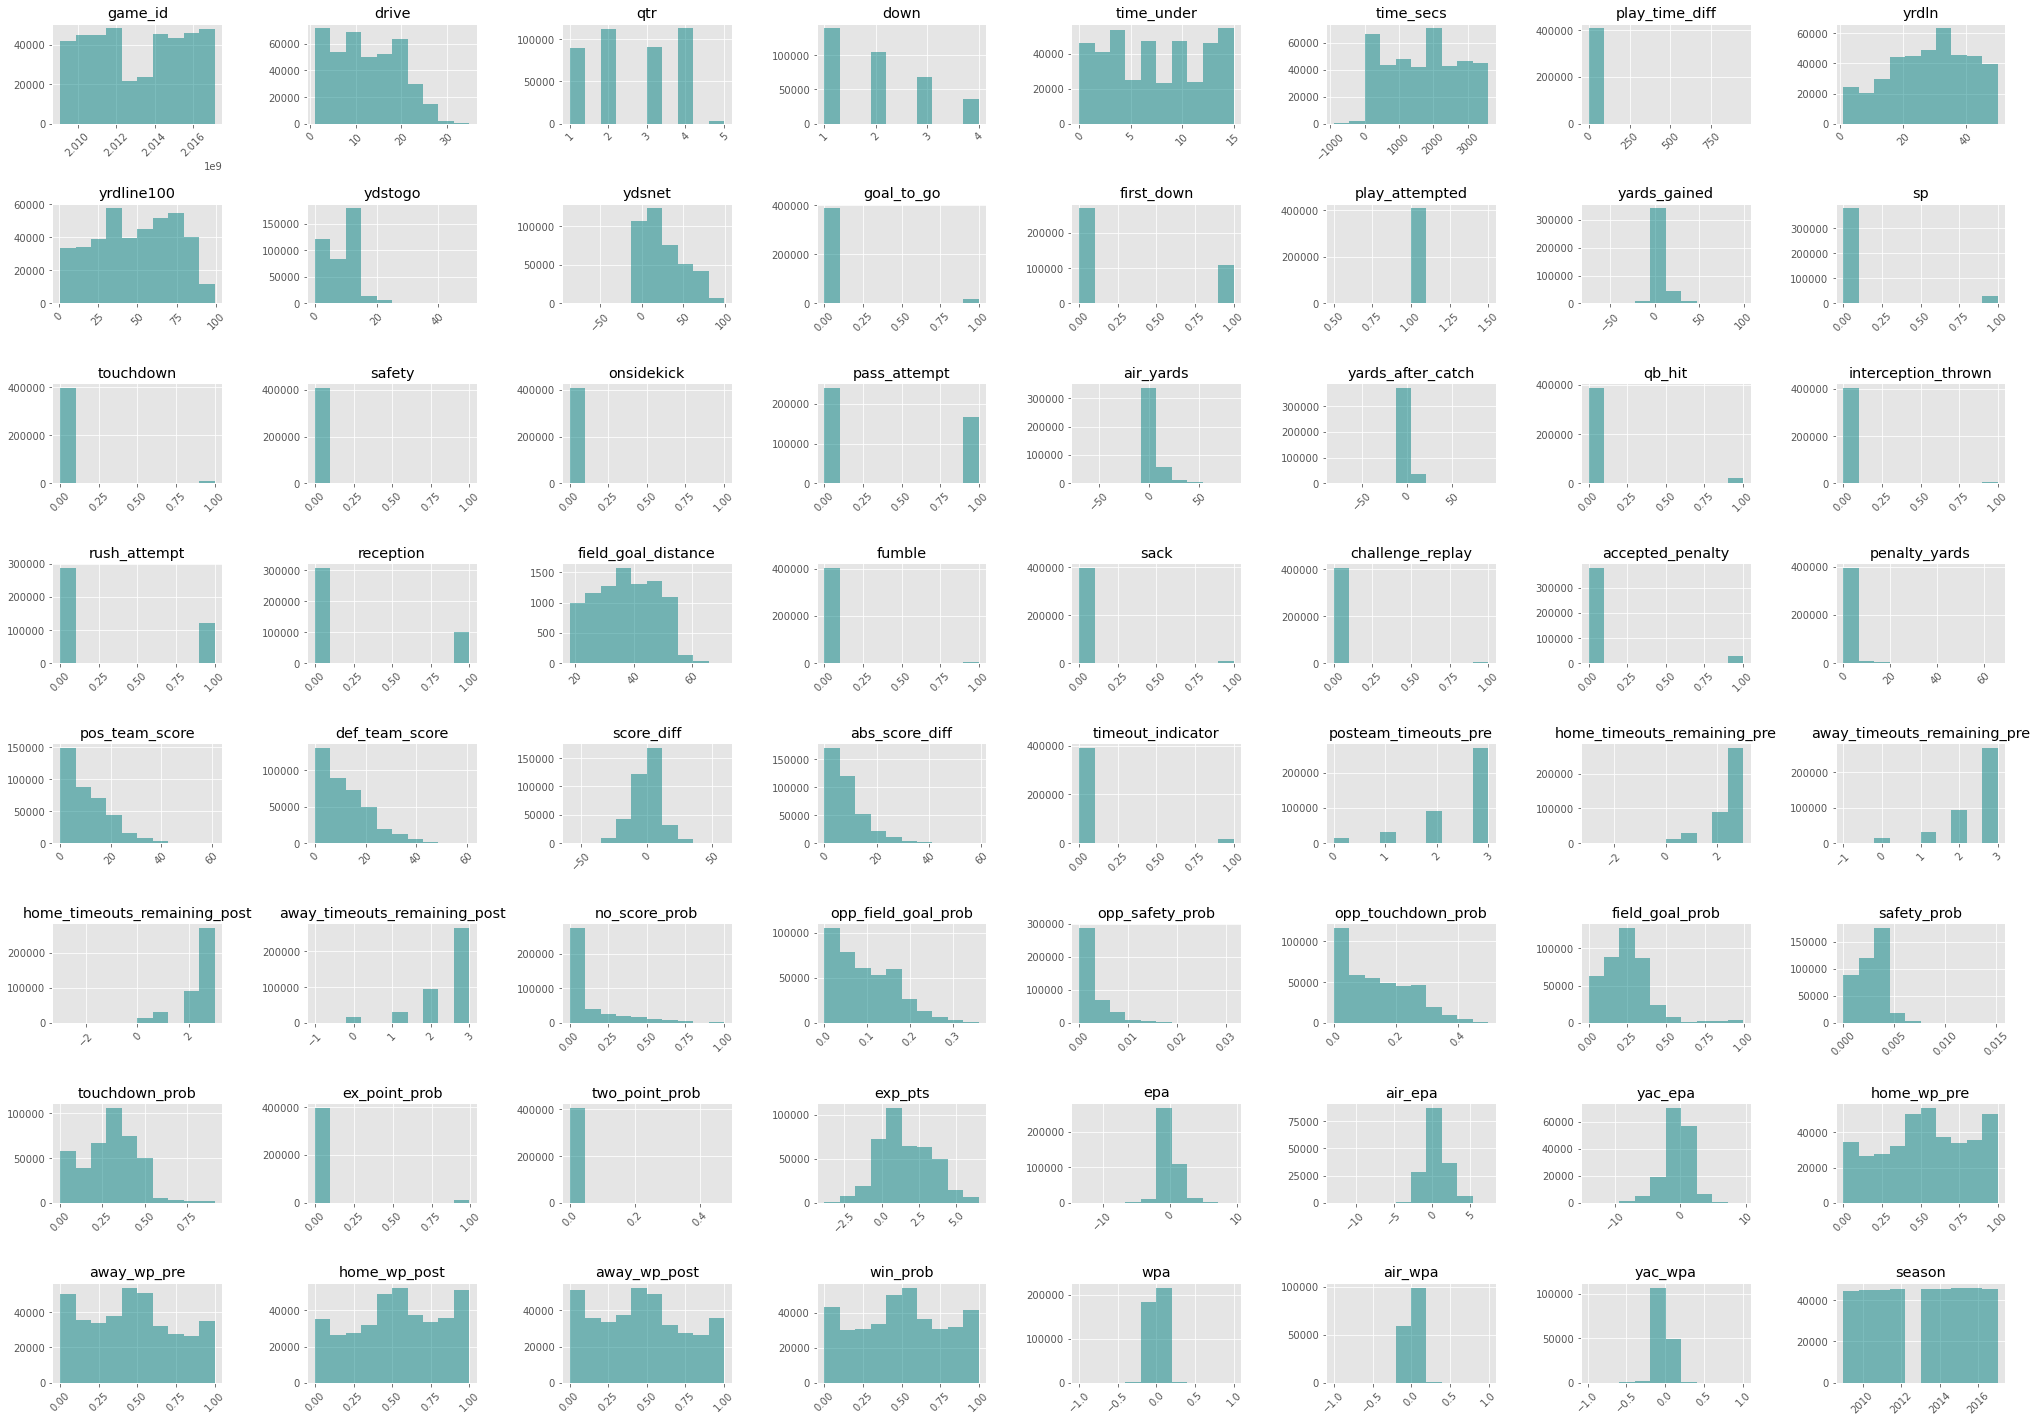

In [159]:
print("Quick cursory look at distributions of all columns - we'll refine this later")
print("Some have good distribution, but there are many nulls - so some of these distributions only apply to a non-null subset of the data")
plt.style.use('ggplot')
data_df.hist(figsize=(35,25), xrot=45, color='teal', alpha=.5)
plt.subplots_adjust(hspace=.8, wspace=.5);
#Hint: notice how the terminating ';' "swallows" some messy output and leads to a tidier notebook

## 04.2 - home teams and away teams

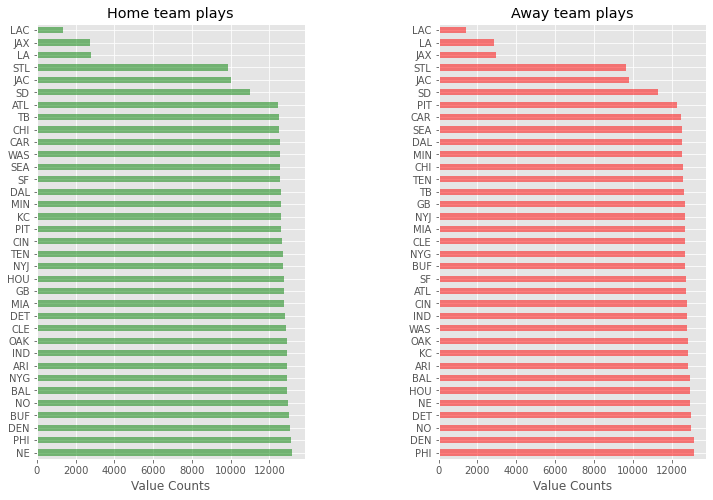

In [160]:
#Create two subplots on 1 row and 2 columns with a figsize of (12, 8)
fig, ax = plt.subplots(1, 2, figsize=(12,8))

#Specify a horizontal barplot ('barh') as kind of plot (kind=)
# ski_data.Region.value_counts().plot(kind='barh', ax=ax[0])
data_df.home_team.value_counts().plot(kind='barh', ax=ax[0], color='green', alpha=.5)
#Give the plot a helpful title of 'Region'
ax[0].set_title('Home team plays')
#Label the xaxis 'Count'
ax[0].set_xlabel('Value Counts')

#Specify a horizontal barplot ('barh') as kind of plot (kind=)
data_df.away_team.value_counts().plot(kind='barh', ax=ax[1], color='red', alpha=.5)
#Give the plot a helpful title of 'state'
ax[1].set_title('Away team plays')
#Label the xaxis 'Count'
ax[1].set_xlabel('Value Counts')

#Give the subplots a little "breathing room" with a wspace of 0.5
plt.subplots_adjust(wspace=0.5);
#You're encouraged to explore a few different figure sizes, orientations, and spacing here
# as the importance of easy-to-read and informative figures is frequently understated


# 05 - Output results

## 05.1 - save reviewd data to disk

## 05.2 - save metric backup to disk

In [161]:
data_df.to_parquet(OUTPUT_DATA, engine='fastparquet',  compression='snappy')
print("Writing",OUTPUT_DATA)

Writing ../data/interim/nflplaybyplay2009to2016_reviewed_01.parquet


In [162]:
with open(READ_ME, 'w') as f:
    f.write(f"\n{os.path.basename(OUTPUT_DATA)}\treviewed and slightly modified gameplay data - no longer raw")
    f.write(f"\n{os.path.basename(METRICS_TABLE_NAME)}.csv\toptionally - we might save the metrics in a file instead of a database")
    f.write(f"\n{os.path.basename(CATEGORIES_TABLE_NAME)}.csv\toptionally we might save the metrics categories in a file instead of a database")


## 05.3 - load metrics to db
Why load to a database? because it's easier (for me) to explore and annotate the data from an IDE
that is capable of datagrids and quick ad-hoc query

In [163]:

db.load_table(metrics_df, METRICS_TABLE_NAME)
print('Created',METRICS_TABLE_NAME)

db.load_table(categories, CATEGORIES_TABLE_NAME)
print('Created',CATEGORIES_TABLE_NAME)

Created nfl_metrics
Created nfl_categories
